## Logistic Regression

Here the goal is to show how an objective function can be decomposed and solved by ADMM.

For this purpose, this notebook considers solving a classification problem with logistic regression.

### Loss function

minimize: $\sum -[y\log(\hat{y}) + (1-y)\log(1-\hat{y})] + \lambda \|x\|_1$

The problem can be decomposed using one of the approaches presented in __Example_LeastSquares__ notebook.

This notebook shows how to decompose into minimization of cross-entropy and regularization term.

### Steps

1. Devise a computation graph representing the problem as a bipartite graph
2. Implement nodes as Java classes extending org.admm4j.core.Node
3. Create the JSON input defining the graph
4. Execute admm4j
5. Import and analyze results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

### Generate data

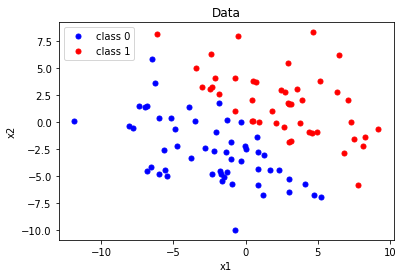

In [2]:
np.random.seed(100)
data = np.random.normal(0, 4, (100,2))
target = np.dot(data, np.array([1,1]))
target[target<=0] = 0
target[target>0] = 1


# plot data
plt.plot(data[target==0,0], data[target==0,1], 'b.', markersize=10)
plt.plot(data[target==1,0], data[target==1,1], 'r.', markersize=10)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Data")
plt.legend(['class 0', 'class 1'])
plt.show()

### Step 1. Devise a computation graph representing the problem as a bipartite graph

The graph shows that the original problem is decomposed into two separate tasks. 

<img src="images/optimizer-regularizer0.png" width="600" height="600" style="float: center"/>

### Step 2. Implement nodes as Java classes extending org.admm4j.core.Node

The following classes are implemented

1. org.admm4j.demo.ml.linearmodel.LogisticRegressionNode.java

2. org.admm4j.demo.common.L1NormNode.java

### Step 3. Create the JSON input defining the graph

The JSON input has a well-defined structure allowing to define an arbitrary bipartite graph.

Here the JSON input is created in python.

In [3]:
# add vector of ones representing bias 
I = np.ones(data.shape[0]).reshape(-1,1)
X = np.concatenate((I, data), axis=1)
y = target

# number of variables and scaling parameter
nvar = X.shape[1] 
rho = 1

# lambda regularization term
_lambda = 0.2 * np.ones(nvar)
_lambda[0] = 0 # we do not want regularize bias term

# init nodesI.
nodesI = []

# define node
node = {}
node['name'] = 'crossentropy'
node['class'] = 'org.admm4j.demo.ml.linearmodel.LogisticRegressionNode'
node['neighbors'] = ['regularization:{}:{}'.format(nvar, rho)] # n and rho are set here, alternatively command line can be used
node['input'] = {'data': X.tolist(), 'target': y.tolist()}

# add to the list of nodesI
nodesI.append(node)


# init nodesII
nodesII = []

node = {}
node['name'] = 'regularization'
node['class'] = 'org.admm4j.demo.common.L1NormNode'
node['neighbors'] = ['crossentropy:{}:{}'.format(nvar, rho)] # n and rho are set here, alternatively command line can be used
node['input'] = {'lambda': _lambda.tolist()}

# add to the list of nodesII
nodesII.append(node)

# init whole json model
graph = {'nodesI': nodesI, 'nodesII': nodesII}

#### Show JSON model

In [4]:
print(json.dumps(graph))

{"nodesI": [{"name": "crossentropy", "class": "org.admm4j.demo.ml.linearmodel.LogisticRegressionNode", "neighbors": ["regularization:3:1"], "input": {"data": [[1.0, -6.99906189221879, 1.3707216133100086], [1.0, 4.612143210254576, -1.0097441460855594], [1.0, 3.9252831478049264, 2.0568753655775285], [1.0, 0.8847186768856018, -4.280173322273173], [1.0, -0.7579833232927013, 1.0200057770935267], [1.0, -1.832107942010497, 1.7406539524915685], [1.0, -2.334380201290659, 3.267388286743116], [1.0, 2.690883222838644, -0.41764457356251083], [1.0, -2.125121507407639, 4.118930740533385], [1.0, -1.7525424908176694, -4.473272985021745], [1.0, 6.4759266427010385, 6.166420698053627], [1.0, -1.007516556852852, -3.3697429530051903], [1.0, 0.7380747622557714, 3.748328804435809], [1.0, 2.924001375339235, 5.446224500581324], [1.0, -1.3049522368092101, 0.22270405941910762], [1.0, 0.8895984342212194, -5.7728679809013475], [1.0, -3.025409222377742, 3.2658160440771433], [1.0, 3.001779046136714, -1.82378770987200

#### Save JSON input file

In [5]:
filename = 'logistic_regression_input.json'
fout = open(filename, 'w')
json.dump(graph, fout, indent=4)
fout.close()

### Step 4. Execute admm4j

#### Note: -nvar and -rho are not specified because they are set in json input

In [6]:
!java -jar admm4j-demo/target/admm4j-demo-1.0-jar-with-dependencies.jar\
           -input logistic_regression_input.json\
           -output logistic_regression_output.json\
           -verbose 10

Iter: 10   Runtime: 105
NodeII: regularization primal: 0.000000 dual: 0.076478
Iter: 20   Runtime: 129
NodeII: regularization primal: 0.000000 dual: 0.029631
Iter: 30   Runtime: 148
NodeII: regularization primal: 0.000000 dual: 0.012560
Iter: 40   Runtime: 164
NodeII: regularization primal: 0.000000 dual: 0.005719
Iter: 50   Runtime: 178
NodeII: regularization primal: 0.000000 dual: 0.002685
Iter: 60   Runtime: 188
NodeII: regularization primal: 0.000000 dual: 0.001282
Iter: 70   Runtime: 196
NodeII: regularization primal: 0.000000 dual: 0.000615
Iter: 80   Runtime: 206
NodeII: regularization primal: 0.000000 dual: 0.000303
Iter: 90   Runtime: 215
NodeII: regularization primal: 0.000000 dual: 0.000143


### Step 5. Import and analyze results

In [7]:
fin = open('logistic_regression_output.json', 'r')
res = json.loads(fin.read())
fin.close()

#### Show results and evaluate performance

In [8]:
coeff = res.get('nodesI')[0].get('variables').get('regularization')

print('Coefficients', coeff)

Coefficients [-0.1268249608153626, 4.970155461703236, 5.024166762173793]


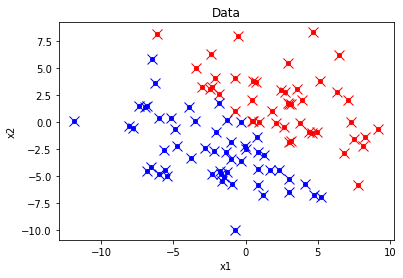

In [9]:
w = np.array(coeff[1:])
b = coeff[0]

z = np.dot(data, w) + b

y_pred = 1. / (1. + np.exp(-z))

plt.plot(data[y_pred<=0.5,0], data[y_pred<=0.5,1], 'bx', markersize=10)
plt.plot(data[y_pred>0.5,0], data[y_pred>0.5,1], 'rx', markersize=10)

plt.plot(data[target==0,0], data[target==0,1], 'b.', markersize=8)
plt.plot(data[target==1,0], data[target==1,1], 'r.', markersize=8)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Data")
plt.show()

The plot shows that the coefficients found for logistic regression model give a good fit to the data.